In [ ]:
!nvidia-smi

Sun Feb 13 21:32:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set up

In [ ]:
import time
from tqdm import tqdm
import pandas as pd
from scipy.stats import pearsonr
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import sklearn.datasets, sklearn.preprocessing, sklearn.model_selection
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import copy
from numpy import linalg as LA
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score
from torchvision import datasets, transforms
import statistics as stats
from sklearn import svm
from sklearn import linear_model
from sklearn.datasets import fetch_california_housing
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/NN_VS/NM/'
# path=''

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def l1(x):
    return torch.sum(abs(x))
def ExU(x, w, b):
    return torch.matmul(torch.exp(w), x-b)
def groupl1(x):
    return torch.norm(x)
def sign(m):
    return torch.sign(m)

# Data Generation

In [ ]:
#, random_state=1
def gen_data(features,n_samples, n_fake_features, sigma, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)
    n_features = n_true_features + n_fake_features
    noise = sigma*np.random.randn(n_samples)
    X = np.random.randn(n_samples, n_features)
    y = np.hstack([feature(X[:, [i]]) for i, feature in enumerate(features)]).sum(axis=1)+noise

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test 

In [ ]:
#%%Three methods for preprocessing datasets
def gen_data_center(features,n_samples, n_fake_features, sigma, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)

    noise = sigma*np.random.randn(n_samples)
    temp_y=[]
    X = np.random.randn(n_samples, n_features)
    y = np.hstack([feature(X[:, [i]]) for i, feature in enumerate(features)]).sum(axis=1)+noise
	
    X -= X.mean(axis=0)
    X /= X.std(axis=0)	
    y -= y.mean()
    
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test 


def gen_data_normal(features,n_samples, n_fake_features, sigma, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)

    noise = sigma*np.random.randn(n_samples)
    temp_y=[]
    X = np.random.randn(n_samples, n_features)
    for i, feature in enumerate(features):
        temp=feature(X[:, [i]])
        new_temp = (temp-np.min(temp))/(np.max(temp)-np.min(temp))
        temp_y.append(new_temp)
    y = np.hstack(temp_y).sum(axis=1)+noise

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test 


def gen_data_cls(features,n_samples, n_fake_features, nseed=1, save=False):

    np.random.seed(nseed)
    
    n_true_features = len(features)
    n_features = n_true_features + n_fake_features

    X = np.random.randn(n_samples, n_features)
    temp = np.hstack([feature(X[:, [i]]) for i, feature in enumerate(features)]).sum(axis=1)
    # temp -= np.mean(temp)
    
    y = [(np.random.binomial(size=1, n=1, p=1.0/(1+np.exp(-logit)))).item() for logit in \
                  temp] 
    y=np.asarray(y)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test 

In [ ]:
def data_totensor(X_train, X_test, y_train, y_test, batch_size = 256, batch_size_test=1000,save=False, MSE=False):
    
    #%% separate data into three parts: train, validation and test. 
    if MSE: 
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)
        D_out = 1
    else:
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).long()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).long()
        D_out = 2

    Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=False)
    Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size_test, shuffle=False)
    
    if save== True:
        f = open(path+"data/p2_data.pkl","wb")
        pickle.dump([trainloader, valloader, testloader, D_out], f)
        f.close()
    
    return trainloader, testloader, D_out 

In [ ]:
#%%Generate data
n_features, n_samples, sigma, seed = 24,3000, 1, 1 # ,500, 1000, 2000, 4000, 8000
thresh=0.01
true_feature=np.zeros(n_features)
true_feature[0]=true_feature[1]=true_feature[2]=true_feature[3]=1
features = [
    lambda x: 2 * x * x * np.tanh(x),
    lambda x: np.sin(x)*np.cos(x)+x**2,
    lambda x: 20. * (1. / (1 + np.exp(-(5. * np.sin(x))))),
    lambda x: 20*np.sin(2*x)**3-6*np.cos(x)+x**2
]
# data_name = 'data_rg'
# data_name = 'data_rg_normal'
# data_name = 'data_rg_center'
data_name = 'data_cls'
# X_train, X_test, y_train, y_test = gen_data_cls(features,n_samples=n_samples, n_fake_features=n_features-len(features), nseed=seed, save=False)
# X_train, X_test, y_train, y_test = gen_data_normal(features,n_samples=n_samples, n_fake_features=n_features-len(features), sigma=sigma, nseed=seed, save=False)
# X_train, X_test, y_train, y_test = gen_data(features,n_samples=n_samples, n_fake_features=n_features-len(features), sigma=sigma, nseed=seed, save=False)
# X_train, X_test, y_train, y_test = gen_data_center(features,n_samples=n_samples, n_fake_features=n_features-len(features), sigma=sigma, nseed=seed, save=False)
# f_r = open(path + data_name+".pkl","wb")
# pickle.dump([X_train, X_test, y_train, y_test], f_r)
# f_r.close()

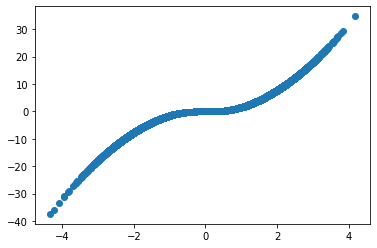

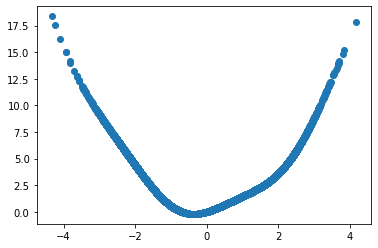

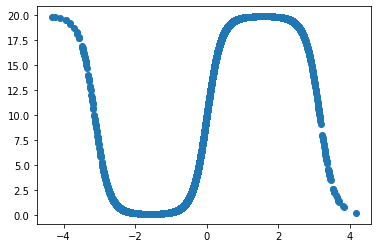

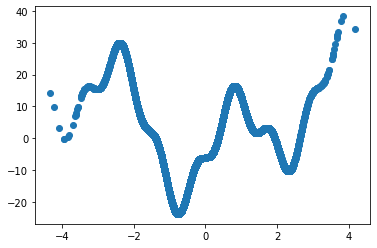

In [ ]:
for i in range(len(features)):
    plt.scatter(X_train, features[i](X_train))
    plt.show()

# Model & Train

In [ ]:
class SampleNet(nn.Module):
    def __init__(self,seed=1, m=100, n_output=1):
        super().__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        # self.fc0 = nn.Linear(1, 1,bias=False)
        self.fc1 = nn.Linear(1, m)
        self.fc2 = nn.Linear(m, 50)
        self.fc3 = nn.Linear(50, n_output, bias=False)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(x)

    def name(self):
        return "CaliforniaNAM_FeatureNN"

In [ ]:
class NAM(nn.Module):
    def __init__(self, feature_size, output_size, ModelA, seed=1, m=100):
        super(NAM, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        self.feature_size = feature_size
        self.output_size = output_size
        self.feature_nns = torch.nn.ModuleList([
            ModelA(seed=seed, m=m, n_output=output_size)
            for i in range(feature_size)
        ])
        self.bias = nn.Parameter(torch.zeros(output_size), requires_grad=True)

        
    def forward(self, input):

        output=self.feature_nns[0](input[:, [0]])+self.bias
        for i in range(1,self.feature_size):
            output+=self.feature_nns[i](input[:,[i]])
        f_out=torch.cat([self.feature_nns[i](input[:, [i]]).reshape(len(input), -1, output_size) for i in range(self.feature_size)], dim=1)
        return [output, f_out]

    def name(self):
        return "CaliforniaNAM"

In [ ]:
def train_sub(trainloader, testloader,n_features, model, optimizer,max_epoch,
          torch_seed=0, test=False, lbd=0.1, MSE=False):


    n_layer=0
    for name, param in model.named_parameters():
        if 'feature_nns.0' in name and 'weight' in name:
            n_layer+=1

    
    model.train()
    if MSE==True:
      criterion=torch.nn.MSELoss()
    else:
      criterion=torch.nn.CrossEntropyLoss()

    
    for epoch in range(max_epoch):
        f_out_tr = []
        total_batch_loss=0
        # total_batch=0
        tr_correct, tr_total = 0, 0
        for idx1, (inputs, targets) in tqdm(enumerate(trainloader)): 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, f_out_tr_temp = model(inputs)[0],model(inputs)[1].detach().cpu().numpy()
            f_out_tr.append(f_out_tr_temp)
            loss=criterion(outputs, targets)
            total_batch_loss += loss.item()
            if MSE == False:
                tr_correct += (torch.argmax(outputs, axis=1) == targets).sum().item()
                tr_total += len(targets)      
            #%%%%%%%%%%%add regularization%%%%%%%%%%%#
            for ind in range(n_features):
                count=1
                reg_loss = torch.tensor(0).float().to(device)
                for name, param in model.named_parameters():                        
                    if 'weight' in name and name.find('feature_nns.'+str(ind)) == 0: 
                        if  count == n_layer:
                            reg_loss+=groupl1(param.T) 
                        count+=1
                loss += lbd*torch.sqrt(reg_loss)
            loss.backward()
            optimizer.step()


        if test==True:
            model.eval()
            test_loss = 0
            test_correct, test_total = 0, 0
            with torch.no_grad():
                for idx2, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs, f_out_te = model(inputs)[0], model(inputs)[1].detach().cpu().numpy()
                    test_loss += criterion(outputs, targets).item()
                    if MSE == False:
                        test_correct += (torch.argmax(outputs, axis=1) == targets).sum().item()
                        test_total += len(targets)
                test_loss = test_loss/(idx2+1)

        
        if (epoch+1)%1==0:
            if MSE == False:
                print('epoch: ', epoch+1, 'Loss train: ', total_batch_loss/(idx1+1), 'ACC train: ', 100*(tr_correct/tr_total))
                print('Loss test: ', test_loss, 'ACC test: ', 100*(test_correct/test_total))
            else:
                print('epoch: ', epoch+1, 'Loss train: ', total_batch_loss/(idx1+1), 'Loss test: ', test_loss)
                    

    #%%%%%%%%%%%%%%%%%%%%%#
    # for support recovery
    # model.eval()
    # test_loss = 0
    # f_out_te = []
    # with torch.no_grad():
    #     for idx, (inputs, targets) in enumerate(testloader):
    #         inputs, targets = inputs.to(device), targets.to(device).reshape(-1)
    #         outputs, f_out_te_temp = model(inputs)[0], model(inputs)[1].detach().cpu().numpy()
    #         f_out_te.append(f_out_te_temp)
    #         test_loss += criterion(outputs, targets).item()
    #     test_loss = test_loss/(idx+1)
    # print('MSE test: ', test_loss) #, 'f_test_out', np.mean(f_out.cpu().detach().numpy(), axis=0)
    
    # mean_f_out = np.mean(f_out_te.cpu().detach().numpy(), axis=0)
    # select_mean_f_out=[1 if abs(a) > threshold else 0 for a in mean_f_out]
    # print(select_mean_f_out, true_feature)
    # print('auc score: ', roc_auc_score(true_feature,mean_f_out))
    
    if MSE == False:
        return [100*(test_correct/test_total), test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model]
    return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model]

In [ ]:
def simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features, output_size,
             opti_name, MSE=False,
             seed=1, RFM=False):


    torch.manual_seed(seed)
    np.random.seed(seed)


    print('training with lbd: ', lbd)
    
    if RFM == True:
        model = RF_Net(NAM(n_features, output_size, SampleNet,seed=1), n_features).to(device)
    else: 
        model = NAM(n_features, output_size, SampleNet,seed=1).to(device) #, MSE=MSE
    
    if opti_name=='SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        train_func=train_sub
    elif opti_name=='Adam': 
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        train_func=train_sub
    else:
        print('wrong name. Pls enter one of them: SGD, ADAM, prox.')
        

    result = train_func(trainloader, testloader, n_features, model, optimizer, max_epoch, torch_seed=0, test=True, lbd=lbd, MSE=MSE) #0.8


    return result

In [ ]:
def iden_errorML(x, coef, features, plot=False):
    #%% the output is generated bu 
    iden_error_list = []
    for i in range(len(coef)):
        f_i_hat = x[:, i]*coef[i]
        if i <len(features):
            f_i = features[i](x[:, i])
        else: f_i = np.zeros_like(f_i_hat)
        c_i=np.mean(f_i_hat-f_i)
        iden_error_list.append(np.mean((f_i_hat-f_i-c_i)**2))
    if plot == True:
        for i in range(len(coef)):
            f_i_hat = x[:, i]*coef[i]
            if i <len(features):
                f_i = features[i](x[:, i])
            else: f_i = np.zeros_like(f_i_hat)
            plt.scatter(x[:, i], f_i, label='truth')
            plt.scatter(x[:, i], f_i_hat, label='prediction')
            plt.legend()
            plt.show()
    return np.mean(iden_error_list)


def iden_error_spam(X_train, f_tr, features, plot=False):
    iden_error=0
    for i in range(f_tr.shape[1]):
        if i < len(features):
            f_i = features[i](X_train[:, [i]])
        else: f_i = np.zeros_like(X_train[:, [i]])
        c_i=np.mean(f_tr[:,[i]]-f_i)
        iden_error+=np.mean((f_tr[:, [i]]-f_i-c_i)**2)

        if plot == True:
            plt.scatter(X_train[:, i], f_tr[:, [i]]-c_i, label='SPAM')
            plt.scatter(X_train[:, i], f_i, label='Truth')
            plt.legend()
            plt.xlabel("x")
            plt.ylabel("f(x)")
            plt.show()
    # print('iden error: ', iden_error/len(features))
    return iden_error/len(features)

In [ ]:
def RF_Net(model, n_features):
    n_layer=0
    for name, param in model.named_parameters():
        if 'feature_nns.0' in name and 'weight' in name:
            n_layer+=1
    for ind in range(n_features):
        count=1
        for name, param in model.named_parameters():    
            if 'weight' in name and name.find('feature_nns.'+str(ind)) == 0: 
                # print(name,count)
                if  count != n_layer:
                    param.requires_grad = False 
                count+=1
            elif 'bias' in name:
                param.requires_grad = False 
    
    return model

In [ ]:
###% test
#n_features
model = RF_Net(NAM(5, 1, SampleNet).to(device), 5)
for name, param in model.named_parameters():
  if param.requires_grad == True:
    print(name)

feature_nns.0.fc3.weight
feature_nns.1.fc3.weight
feature_nns.2.fc3.weight
feature_nns.3.fc3.weight
feature_nns.4.fc3.weight


### l1_SVM

#### classification

In [ ]:
data_name = 'data_cls'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

lin_clf = svm.LinearSVC(penalty='l1', dual=False, C=0.02)
lin_clf.fit(X_train, y_train)
y_test_pred = lin_clf.predict(X_test)
time_spent =  time.time()-start 

# iden_loss = iden_error(X_test, lin_clf.coef_.reshape(-1), features, plot=True)

print('f_train_out: ', lin_clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_test)**2))
print('test acc: ', lin_clf.score(X_test, y_test))
print('precision: ', precision_score(true_feature,abs(lin_clf.coef_.reshape(-1))>0.01))
print('recall: ', recall_score(true_feature,abs(lin_clf.coef_.reshape(-1))>0.01))
# print('iden error: ', iden_loss)

f_train_out:  [[ 0.11840514  0.0167962   0.34923735  0.27129562  0.          0.
  -0.00331265  0.00916333  0.          0.          0.01993896  0.
   0.00141252  0.          0.          0.          0.         -0.02181068
  -0.01326776 -0.00195171  0.          0.00367914  0.         -0.00321704]]
time spent:  0.005042314529418945  sec
test loss:  0.2683333333333333
test acc:  0.7316666666666667
AUC score:  0.9750000000000001
precision:  0.5714285714285714
recall:  1.0


#### regression

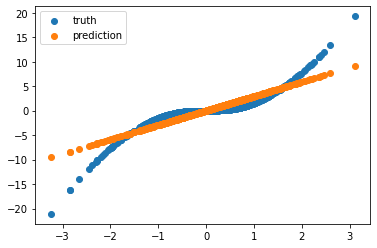

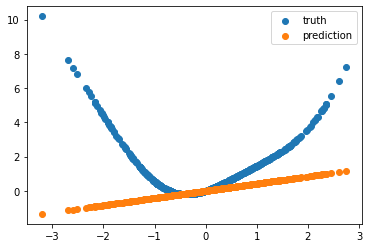

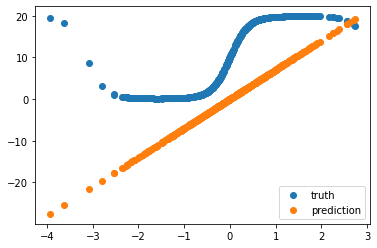

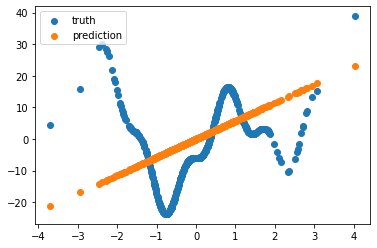

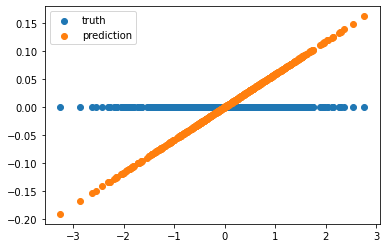

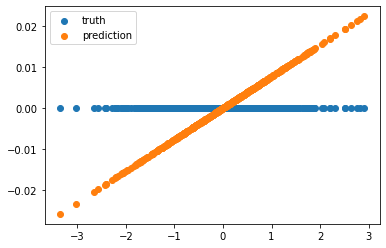

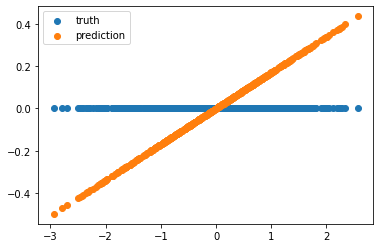

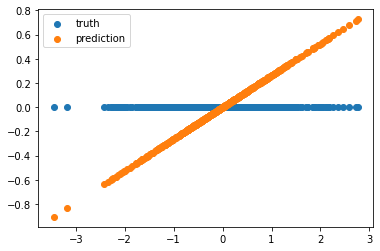

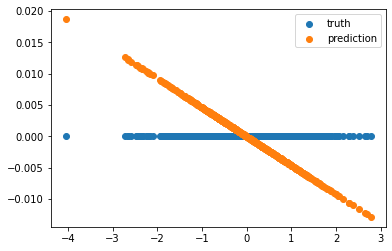

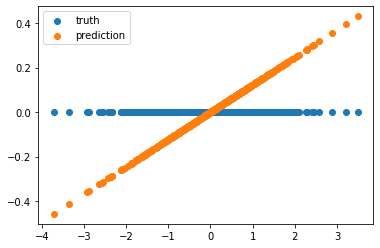

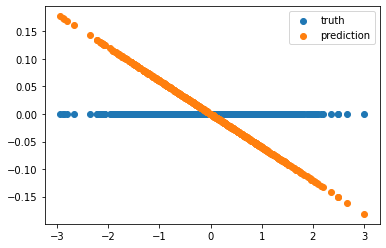

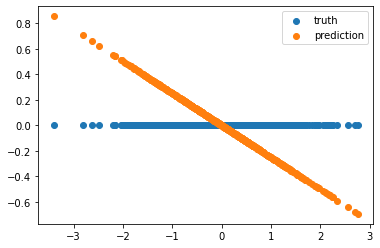

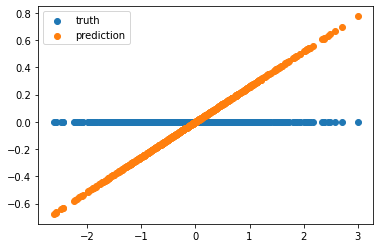

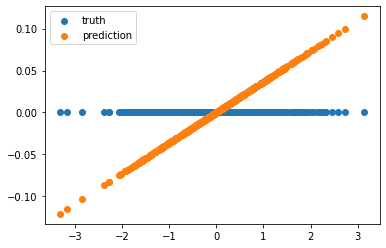

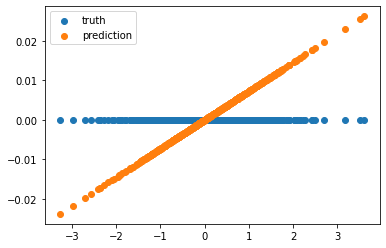

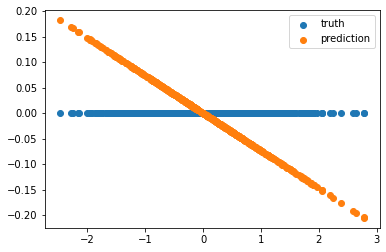

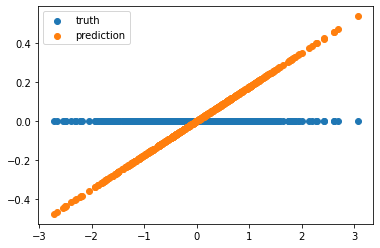

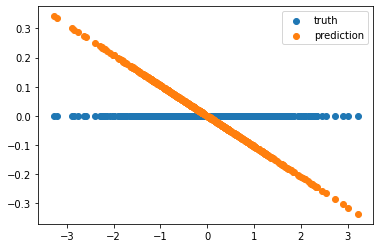

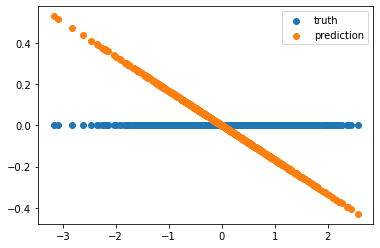

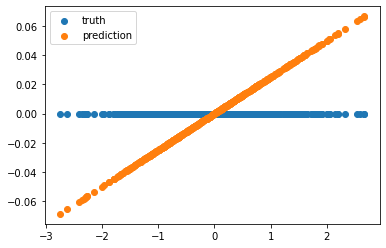

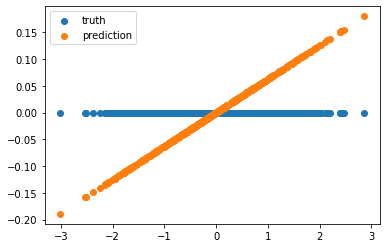

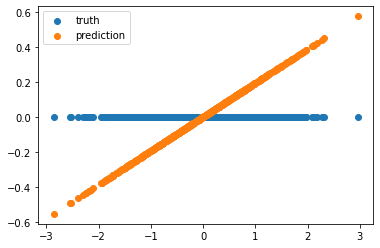

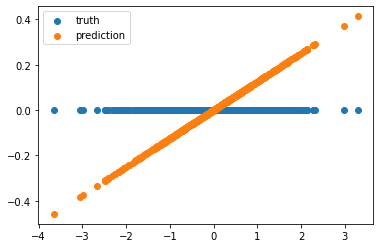

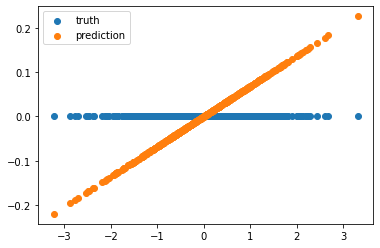

f_train_out:  [ 2.93908690e+00  4.20730090e-01  7.01389370e+00  5.75258134e+00
  5.86775176e-02  7.66368700e-03  1.69722408e-01  2.62619174e-01
 -4.62446870e-03  1.23174840e-01 -6.03158561e-02 -2.51163550e-01
  2.57569974e-01  3.65744114e-02  7.25517588e-03 -7.37069894e-02
  1.74384893e-01 -1.04171778e-01 -1.66896676e-01  2.48991859e-02
  6.28270820e-02  1.93767169e-01  1.25228250e-01  6.80865450e-02]
time spent:  0.003149271011352539  sec
test loss:  140.6102274385112
precision:  0.19047619047619047
recall:  1.0
iden error:  5.9046060836005045


In [ ]:
data_name='data_rg'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

lin_clf = svm.LinearSVR(C=0.1)
lin_clf.fit(X_train, y_train)
# dec = lin_clf.decision_function(X_test)
y_test_pred = lin_clf.predict(X_test)
time_spent =  time.time()-start 



iden_loss = iden_errorML(X_test, lin_clf.coef_, features, plot=True)

print('f_train_out: ', lin_clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_test)**2))
print('precision: ', precision_score(true_feature,abs(lin_clf.coef_.reshape(-1))>0.01))
print('recall: ', recall_score(true_feature,abs(lin_clf.coef_.reshape(-1))>0.01))
print('iden error: ', iden_loss)

In [ ]:
##%%save
# f = open(path+"plot_synRG_l1svm.pkl","wb")
# pickle.dump([lin_clf.coef_, lin_clf], f)
# f.close()

##%%load
[lin_clf.coef_, lin_clf] = \
pickle.load(open(path+"plot_synRG_l1svm.pkl", "rb"))

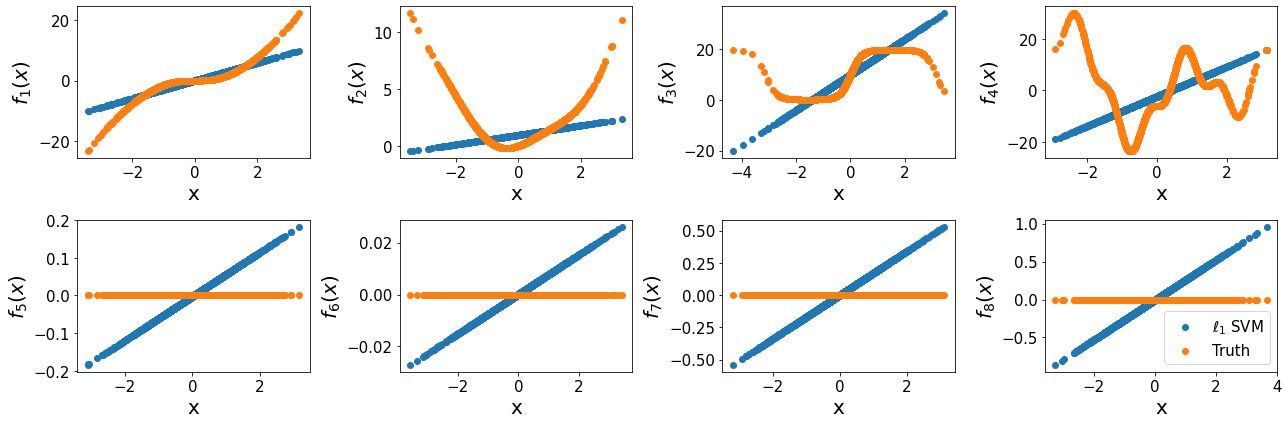

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        f_i_hat = X_train[:, i]*lin_clf.coef_[i]
        c_i=np.mean(f_i_hat-f_i) 
        col.scatter(X_train[:, i], f_i_hat-c_i, label=r'$\ell_1$ SVM')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_l1svm.pdf', bbox_inches='tight')
plt.show()        

### LASSO

#### classification

In [ ]:
data_name = 'data_cls'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))

start = time.time()

clf = LogisticRegression(C=0.04,penalty='l1', solver='saga')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
time_spent =  time.time()-start 

# iden_loss = iden_error(X_test, clf.coef_.reshape(-1), features, plot=True)

print('f_train_out: ', clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_test)**2))
print('test acc: ', clf.score(X_test, y_test))
print('precision: ', precision_score(true_feature,abs(clf.coef_.reshape(-1))>0.01))
print('recall: ', recall_score(true_feature,abs(clf.coef_.reshape(-1))>0.01))
# print('iden error: ', iden_loss)

f_train_out:  [[ 0.29366124  0.0164188   0.92359529  0.69855877  0.          0.
   0.          0.          0.          0.          0.01886835  0.
   0.          0.          0.          0.          0.         -0.02450697
   0.          0.          0.          0.          0.          0.        ]]
time spent:  0.01603078842163086  sec
test loss:  0.25833333333333336
test acc:  0.7416666666666667
AUC score:  0.9750000000000001
precision:  0.6666666666666666
recall:  1.0


#### regression

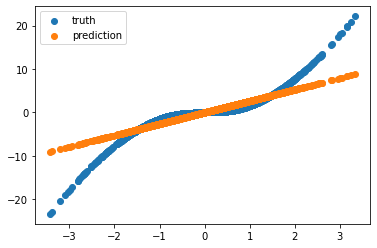

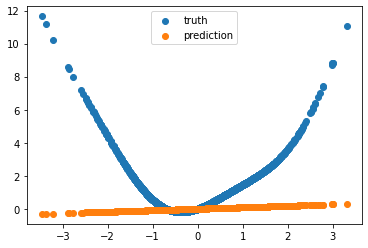

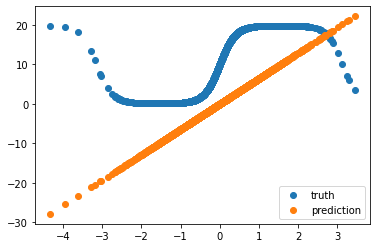

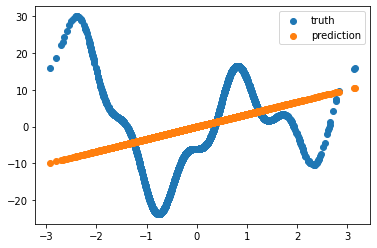

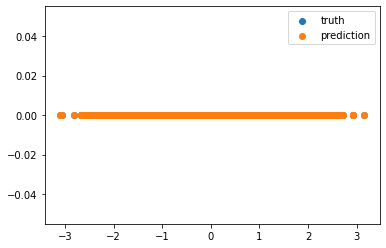

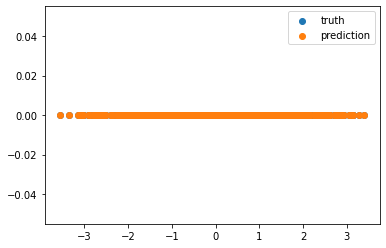

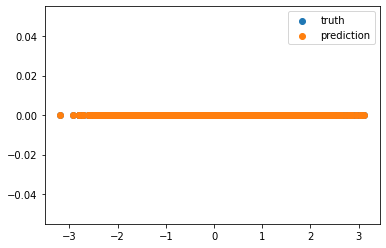

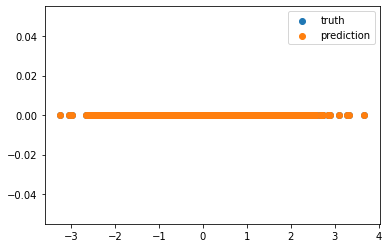

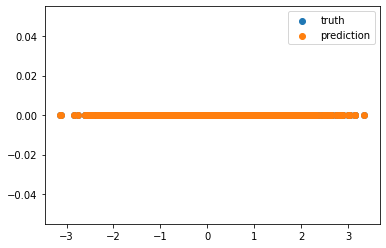

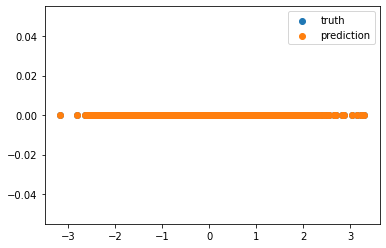

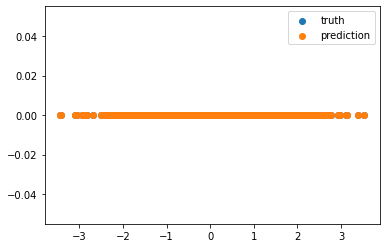

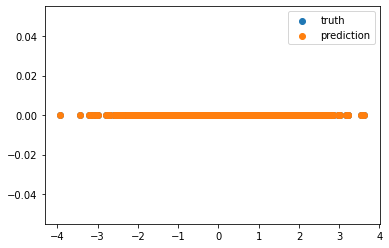

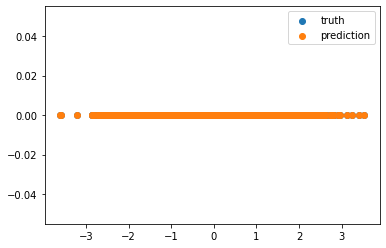

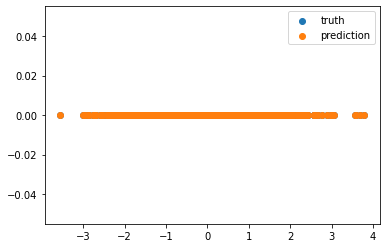

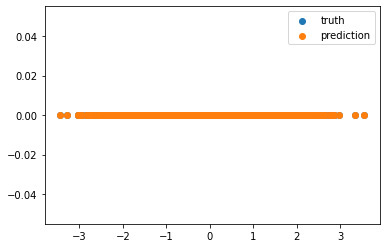

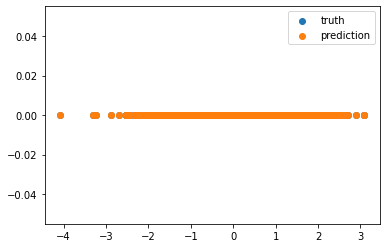

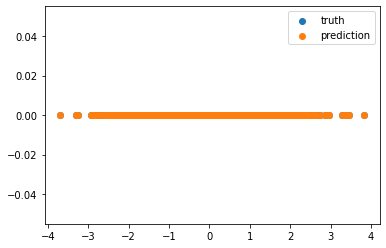

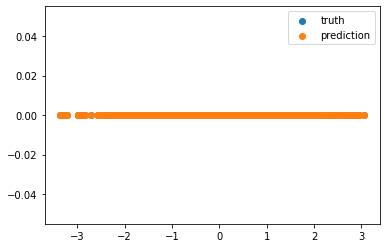

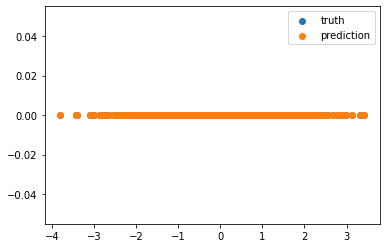

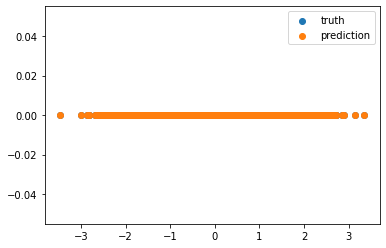

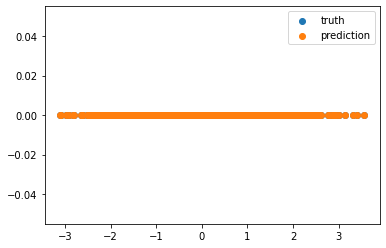

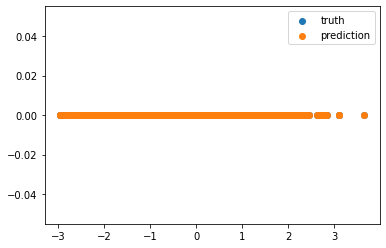

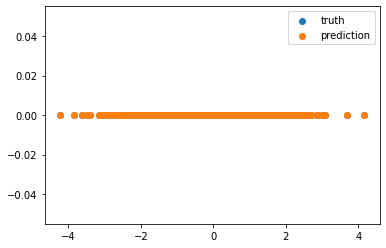

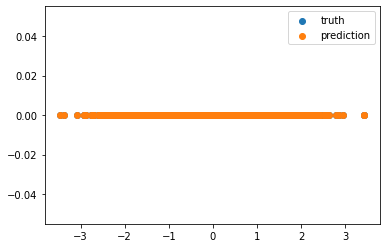

f_train_out:  [ 2.63193165  0.08935845  6.4353392   3.37055046 -0.          0.
  0.          0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.        ]
time spent:  0.0057413578033447266  sec
test loss:  139.64873218985565
precision:  1.0
recall:  1.0
iden error:  6.0927150224760735


In [ ]:
data_name = 'data_rg'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

clf = Lasso(alpha=0.5)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
time_spent =  time.time()-start 

iden_loss = iden_errorML(X_train, clf.coef_, features, plot=True)
print('f_train_out: ', clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_test)**2))
print('precision: ', precision_score(true_feature,abs(clf.coef_)>0.01))
print('recall: ', recall_score(true_feature,abs(clf.coef_)>0.01))
print('iden error: ', iden_loss)

In [ ]:
##%%save
# f = open(path+"plot_synRG_lasso.pkl","wb")
# pickle.dump([clf.coef_, clf], f)
# f.close()

# ##%%load
[clf.coef_, clf] = \
pickle.load(open(path+"plot_synRG_lasso.pkl", "rb"))

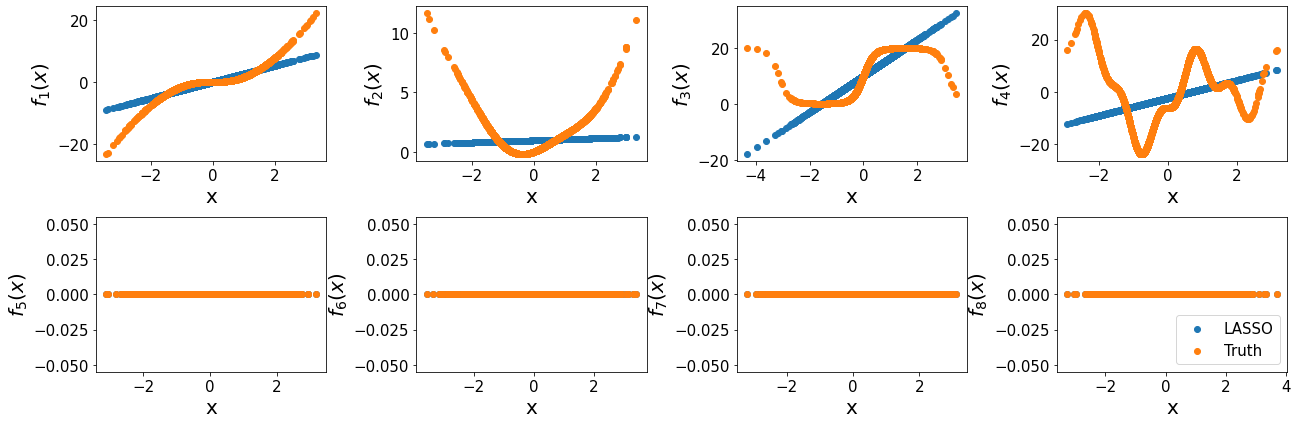

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        f_i_hat = X_train[:, i]*clf.coef_[i]
        c_i=np.mean(f_i_hat-f_i) 
        col.scatter(X_train[:, i], f_i_hat-c_i, label='LASSO')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_lasso.pdf', bbox_inches='tight')
plt.show()        

### SPAM
https://gist.github.com/fabianp/10349186

#### regression

In [ ]:
!pip install moepy --no-dependencies
# !pip install matplotlib==3.1.3
from math import ceil
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from moepy import lowess



"""
Implements the Sparse additive models described in Ravikumar, Pradeep D., et al. 
"SpAM: Sparse Additive Models." NIPS. 2007.
"""
# from loess import lowess


# VERBOSE = 10


def spam_coord_descent(X_train, X_test, y_train, y_test, alpha=1., max_iter=1000, tol=1e-2, f_tr_init=None,
                       ):#loess_f=2. / 3., loess_iter=3

    n_tr_samples, n_tr_features = X_train.shape
    inv_sqrt_n_tr_samples = 1. / np.sqrt(n_tr_samples)

    n_te_samples, n_te_features = X_test.shape
    inv_sqrt_n_te_samples = 1. / np.sqrt(n_te_samples)

    # initialize some variables
    outer_iteration_counter = 0

    # if f_init is None, set it to 0
    if f_tr_init is None:
        f_tr = np.zeros([n_tr_samples, n_tr_features], dtype=X_train.dtype)
    else:
        f_tr = f_tr_init.copy()

    # calculate residue
    R_tr = y_train - f_tr.sum(axis=1)

    while outer_iteration_counter < max_iter:
        R_tr_old = R_tr.copy()
        outer_iteration_counter += 1
        y_hat_test=0
        # poly=[]
        lowess_func_list = []
        for j in range(n_features):
            R_tr += f_tr[:, j]

            lowess_modelj = lowess.Lowess()
            lowess_modelj.fit(X_train[:, j], R_tr) #, frac=0.25
            P_tr_j = lowess_modelj.predict(X_train[:, j])
            # print(P_tr_j)
            lowess_func_list.append(lowess_modelj)

            s_tr_j = inv_sqrt_n_tr_samples * np.sqrt((P_tr_j ** 2).sum())

            # soft threshold
            soft_thresh = 1. - alpha / s_tr_j
            if soft_thresh > 0:
                f_tr_j = soft_thresh * P_tr_j
                f_tr_j -= f_tr_j.mean()
                f_tr[:, j] = f_tr_j[:]
                R_tr[:] -= f_tr_j[:]
            else:
                f_tr[:, j] = 0.

        max_inc = linalg.norm(R_tr-R_tr_old) 
        tr_error = np.mean((np.sum(f_tr, axis=1)-y_train)**2)
        print('MSE_tr', tr_error)

        
        if max_inc < tol / 2:
            break

    f_te = np.zeros([n_te_samples, n_tr_features], dtype=X_train.dtype)    
    for j in range(n_features):
    #%%% test error for y
        P_te_j = lowess_func_list[j].predict(X_test[:, j])
        s_te_j = inv_sqrt_n_te_samples * np.sqrt((P_te_j ** 2).sum())
        # soft threshold
        soft_thresh = 1. - alpha / s_te_j
        if soft_thresh > 0:
            f_te_j = soft_thresh * P_te_j
            f_te_j -= f_te_j.mean()
            f_te[:, j] = f_te_j[:]

        else:
            f_te[:, j] = 0.
    
    temp_mean = np.mean(np.sum(f_tr, axis=1)-y_train)
    te_error = np.mean((np.sum(f_te, axis=1)-y_test-temp_mean)**2)

    # te_error = np.mean((np.sum(f_te, axis=1)-y_test)**2)
    print('MSE_te', te_error)


    return te_error, f_tr, f_te

MSE_tr 84.78303278234843
MSE_te 25.748341501521693


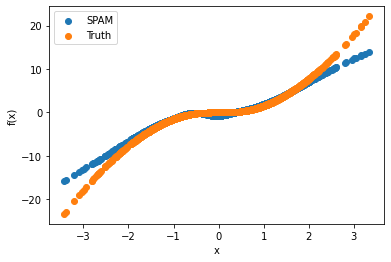

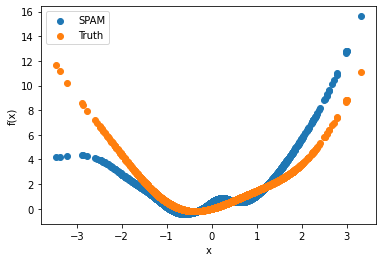

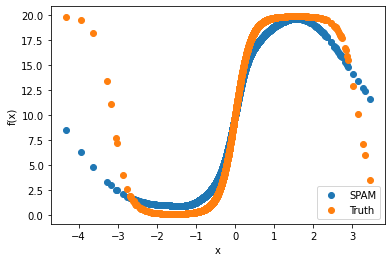

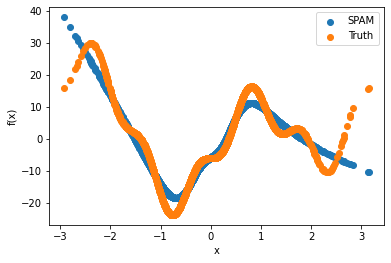

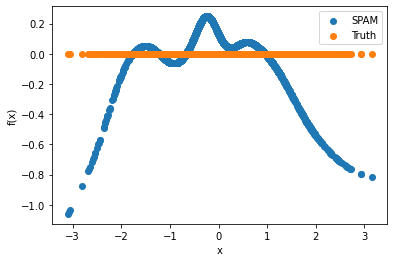

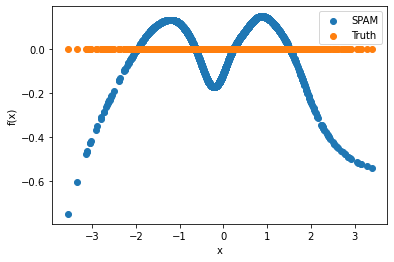

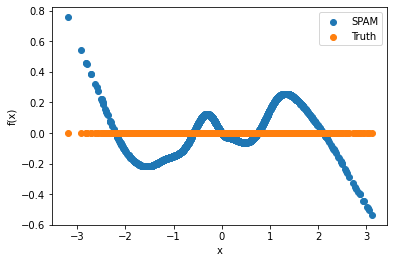

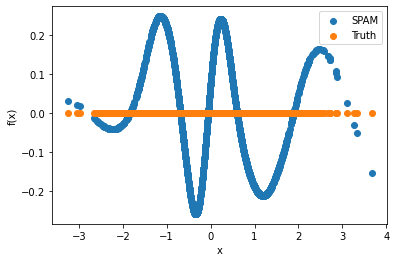

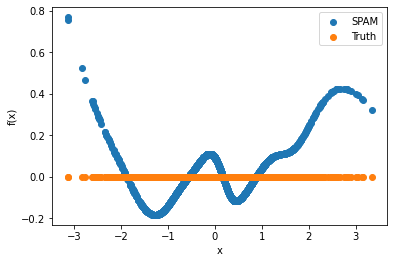

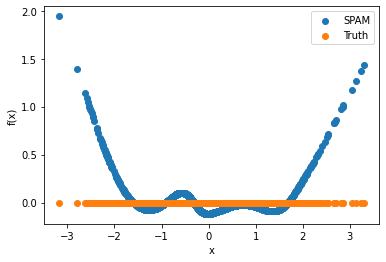

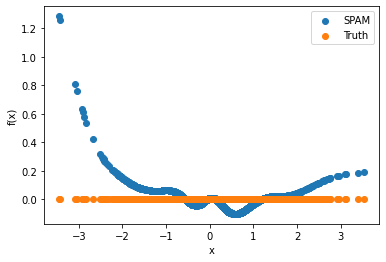

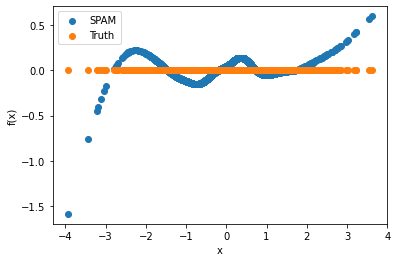

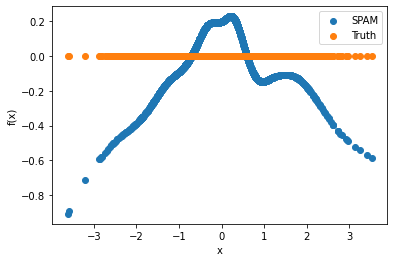

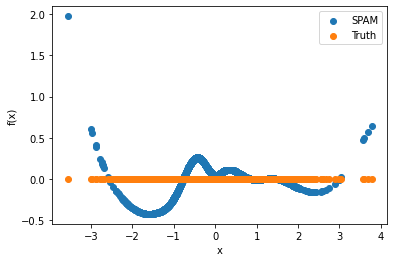

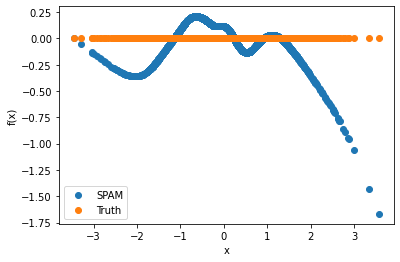

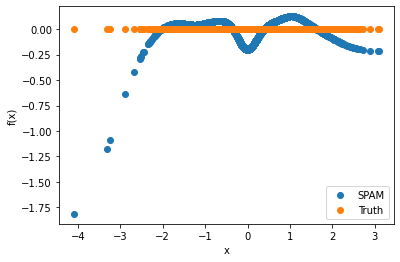

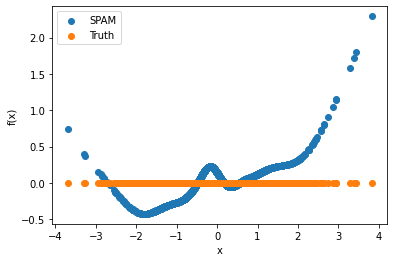

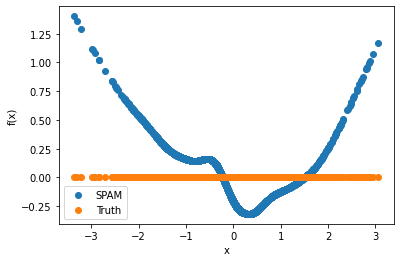

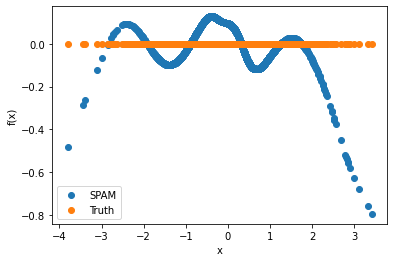

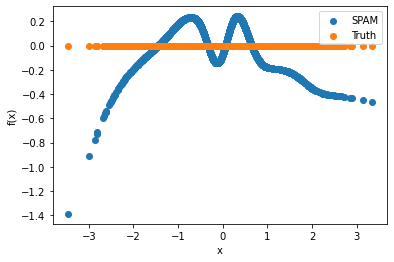

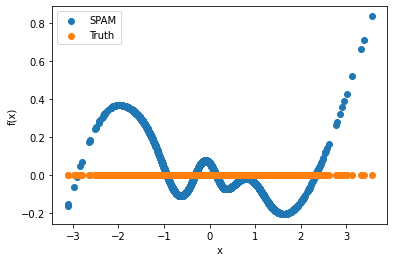

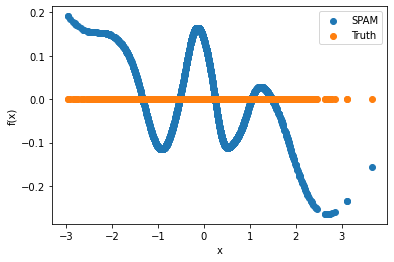

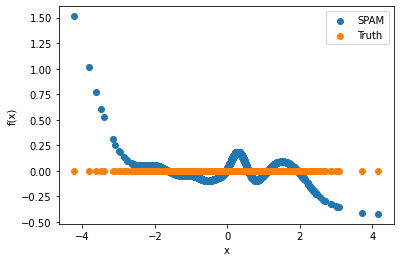

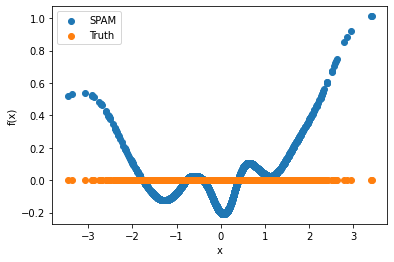

f_train_out [ 5.68434189e-16 -1.46549439e-16  7.39408534e-16 -7.03881398e-16
  1.87257617e-16  1.36002321e-15 -7.88628422e-16  2.30556315e-16
 -1.12872674e-15  4.66293670e-17  3.05311332e-16 -7.59762623e-16
 -1.84297022e-16  1.00660221e-16  7.27566155e-16 -1.68383825e-16
  4.88498131e-17 -4.57781960e-16 -9.59972842e-16  1.25936298e-15
 -8.10092734e-16  6.04331400e-16 -1.34707060e-16  1.75785312e-16]
time spent:  150.3356375694275  sec
test loss:  25.748341501521693
AUC score:  0.9228722480727829
precision:  0.16666666666666666
recall:  1.0
iden error:  3.0688477861515486


In [ ]:
data_name = 'data_rg'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))

start = time.time()
te_error, f_tr, f_te = spam_coord_descent(X_train, X_test, y_train, y_test, alpha=1,max_iter=1)
time_spent =  time.time()-start 
iden_error = iden_error_spam(X_train, f_tr, features, plot=True)
print('f_train_out', np.mean(f_tr, axis=0)) #, alpha=.6, loess_f=.6 
print('time spent: ', time_spent, ' sec')
print('test loss: ', te_error)
print('precision: ', precision_score(true_feature,np.mean(np.abs(f_tr), axis=0)>0.01))
print('recall: ', recall_score(true_feature,np.mean(np.abs(f_tr), axis=0)>0.01))
print('iden error: ', iden_error)

In [ ]:
##%%save
# f = open(path+"plot_synRG_spam.pkl","wb")
# pickle.dump([te_error, f_tr, f_te], f)
# f.close()

# ##%%load
[te_error, f_tr, f_te] = \
pickle.load(open(path+"plot_synRG_spam.pkl", "rb"))

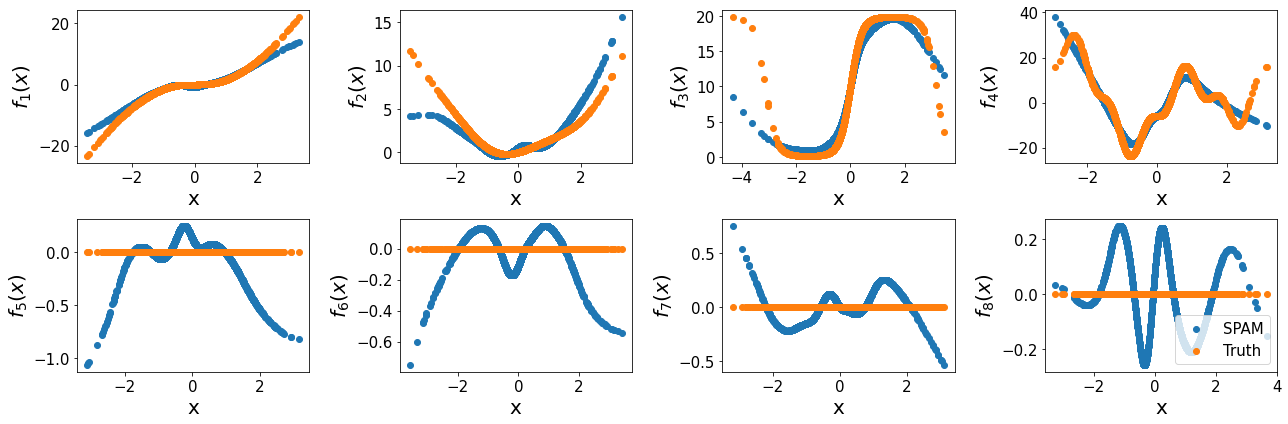

In [ ]:
for i in range(f_tr.shape[1]):
    if i < len(features):
        f_i = features[i](X_train[:, i])
    else: f_i = np.zeros_like(X_train[:, i])
    c_i=np.mean(f_tr[:,[i]]-f_i)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        c_i=np.mean(f_tr[:,[i]]-f_i) 

        col.scatter(X_train[:, i], f_tr[:, [i]]-c_i, label='SPAM')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_spam.pdf', bbox_inches='tight')
plt.show()        

### SNAM

#### classification

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
count = 0
for p in model.parameters():
  count += sum(np.abs(p.detach().cpu().flatten())>0.01)
print('non-zero #of params %i / %i' % (count, total_params))

non-zero #of params 114662 / 128402


In [ ]:
data_name = 'data_cls'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))

lbd, lr, max_epoch, MSE, n_features=0.04, 5e-3, int(20), False, X_train.shape[1]
trainloader, testloader, output_size = data_totensor(X_train, X_test, y_train, y_test, batch_size=256, MSE=MSE)

start = time.time()
[test_acc,test_loss, f_out_tr, f_out_te, model] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=2, opti_name='Adam', 
                   MSE=MSE)
time_spent =  time.time()-start 

# print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)
print('test acc: ', test_acc)
print('precision: ', precision_score(true_feature,np.mean(LA.norm(f_out_tr, axis=2), axis=0).reshape(-1)>0.01))
print('recall: ', recall_score(true_feature,np.mean(LA.norm(f_out_tr, axis=2), axis=0).reshape(-1)>0.01))

training with lbd:  0.04


10it [00:00, 21.91it/s]


epoch:  1 Loss train:  1.5454973876476288 ACC train:  62.66666666666667
Loss test:  1.1482576131820679 ACC test:  67.5


10it [00:00, 19.87it/s]


epoch:  2 Loss train:  0.6291712254285813 ACC train:  70.33333333333334
Loss test:  0.37111446261405945 ACC test:  83.66666666666667


10it [00:00, 21.82it/s]


epoch:  3 Loss train:  0.4093173712491989 ACC train:  79.91666666666667
Loss test:  0.3202495574951172 ACC test:  88.83333333333333


10it [00:00, 21.94it/s]


epoch:  4 Loss train:  0.3113572672009468 ACC train:  88.95833333333333
Loss test:  0.28533679246902466 ACC test:  89.0


10it [00:00, 21.01it/s]


epoch:  5 Loss train:  0.2710744351148605 ACC train:  90.125
Loss test:  0.24284355342388153 ACC test:  93.0


10it [00:00, 20.87it/s]


epoch:  6 Loss train:  0.2243315413594246 ACC train:  92.41666666666667
Loss test:  0.21899273991584778 ACC test:  92.16666666666666


10it [00:00, 21.43it/s]


epoch:  7 Loss train:  0.20200883597135544 ACC train:  92.79166666666666
Loss test:  0.19621922075748444 ACC test:  94.0


10it [00:00, 21.42it/s]


epoch:  8 Loss train:  0.1807100385427475 ACC train:  93.54166666666667
Loss test:  0.1765131950378418 ACC test:  94.0


10it [00:00, 21.33it/s]


epoch:  9 Loss train:  0.1631952404975891 ACC train:  93.875
Loss test:  0.16474981606006622 ACC test:  93.66666666666667


10it [00:00, 20.21it/s]


epoch:  10 Loss train:  0.15334928706288337 ACC train:  93.70833333333334
Loss test:  0.15728329122066498 ACC test:  94.0


10it [00:00, 21.56it/s]


epoch:  11 Loss train:  0.1478235326707363 ACC train:  93.79166666666666
Loss test:  0.15271615982055664 ACC test:  94.0


10it [00:00, 21.48it/s]


epoch:  12 Loss train:  0.14372676312923433 ACC train:  93.83333333333333
Loss test:  0.1504664123058319 ACC test:  93.5


10it [00:00, 21.66it/s]


epoch:  13 Loss train:  0.14061778411269188 ACC train:  93.91666666666667
Loss test:  0.1501014232635498 ACC test:  93.66666666666667


10it [00:00, 21.21it/s]


epoch:  14 Loss train:  0.13934614583849908 ACC train:  93.70833333333334
Loss test:  0.14992327988147736 ACC test:  93.5


10it [00:00, 21.51it/s]


epoch:  15 Loss train:  0.13674687445163727 ACC train:  94.04166666666667
Loss test:  0.14602477848529816 ACC test:  94.33333333333334


10it [00:00, 21.58it/s]


epoch:  16 Loss train:  0.13293563574552536 ACC train:  94.375
Loss test:  0.14599613845348358 ACC test:  94.16666666666667


10it [00:00, 21.69it/s]


epoch:  17 Loss train:  0.13213758170604706 ACC train:  94.375
Loss test:  0.1465914249420166 ACC test:  94.16666666666667


10it [00:00, 21.81it/s]


epoch:  18 Loss train:  0.13058059364557267 ACC train:  94.5
Loss test:  0.14401385188102722 ACC test:  94.16666666666667


10it [00:00, 21.82it/s]


epoch:  19 Loss train:  0.12817576304078102 ACC train:  94.625
Loss test:  0.14536619186401367 ACC test:  94.16666666666667


10it [00:00, 21.57it/s]

epoch:  20 Loss train:  0.12848882228136063 ACC train:  94.66666666666667
Loss test:  0.14448215067386627 ACC test:  94.16666666666667
time spent:  10.105234146118164  sec
test loss:  0.14448215067386627
test acc:  94.16666666666667
AUC score:  1.0
precision:  1.0
recall:  1.0



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#### regression

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
count = 0
for p in model.parameters():
  count += sum(np.abs(p.detach().cpu().flatten())>0.01)
print('non-zero #of params %i / %i' % (count, total_params))

non-zero #of params 114971 / 127201


training with lbd:  2


10it [00:00, 20.79it/s]


epoch:  1 Loss train:  215.644775390625 Loss test:  182.01499938964844


10it [00:00, 21.56it/s]


epoch:  2 Loss train:  168.93063659667968 Loss test:  141.0023193359375


10it [00:00, 20.68it/s]


epoch:  3 Loss train:  122.97718048095703 Loss test:  103.13585662841797


10it [00:00, 21.41it/s]


epoch:  4 Loss train:  99.02747268676758 Loss test:  87.2074966430664


10it [00:00, 20.50it/s]


epoch:  5 Loss train:  78.67984924316406 Loss test:  67.740966796875


10it [00:00, 21.03it/s]


epoch:  6 Loss train:  56.12266311645508 Loss test:  46.66398620605469


10it [00:00, 20.79it/s]


epoch:  7 Loss train:  35.519873428344724 Loss test:  32.36469268798828


10it [00:00, 21.36it/s]


epoch:  8 Loss train:  22.24006042480469 Loss test:  27.627826690673828


10it [00:00, 17.80it/s]


epoch:  9 Loss train:  16.525813007354735 Loss test:  27.791061401367188


10it [00:00, 21.57it/s]


epoch:  10 Loss train:  14.168784618377686 Loss test:  27.18415069580078


10it [00:00, 21.15it/s]


epoch:  11 Loss train:  12.875370597839355 Loss test:  25.734304428100586


10it [00:00, 21.22it/s]


epoch:  12 Loss train:  12.110868835449219 Loss test:  24.476224899291992


10it [00:00, 21.66it/s]


epoch:  13 Loss train:  11.621203517913818 Loss test:  23.381723403930664


10it [00:00, 21.46it/s]


epoch:  14 Loss train:  11.222176456451416 Loss test:  22.486921310424805


10it [00:00, 20.81it/s]


epoch:  15 Loss train:  10.83601999282837 Loss test:  21.754701614379883


10it [00:00, 19.27it/s]


epoch:  16 Loss train:  10.477733993530274 Loss test:  21.160125732421875


10it [00:00, 21.72it/s]


epoch:  17 Loss train:  10.1596248626709 Loss test:  20.65277671813965


10it [00:00, 21.54it/s]


epoch:  18 Loss train:  9.88357925415039 Loss test:  20.245162963867188


10it [00:00, 21.56it/s]


epoch:  19 Loss train:  9.625757598876953 Loss test:  19.85312843322754


10it [00:00, 21.59it/s]


epoch:  20 Loss train:  9.3959228515625 Loss test:  19.480030059814453


10it [00:00, 20.49it/s]


epoch:  21 Loss train:  9.190587663650513 Loss test:  19.183923721313477


10it [00:00, 21.28it/s]


epoch:  22 Loss train:  9.010126686096191 Loss test:  18.961200714111328


10it [00:00, 20.33it/s]


epoch:  23 Loss train:  8.848850584030151 Loss test:  18.782390594482422


10it [00:00, 20.87it/s]


epoch:  24 Loss train:  8.69259934425354 Loss test:  18.604461669921875


10it [00:00, 21.78it/s]


epoch:  25 Loss train:  8.54480595588684 Loss test:  18.461698532104492


10it [00:00, 20.69it/s]


epoch:  26 Loss train:  8.402081489562988 Loss test:  18.340534210205078


10it [00:00, 21.45it/s]


epoch:  27 Loss train:  8.262383031845093 Loss test:  18.222148895263672


10it [00:00, 20.61it/s]


epoch:  28 Loss train:  8.119618368148803 Loss test:  18.082298278808594


10it [00:00, 21.94it/s]


epoch:  29 Loss train:  7.979010391235351 Loss test:  17.93950080871582


10it [00:00, 20.49it/s]


epoch:  30 Loss train:  7.837488603591919 Loss test:  17.80491828918457


10it [00:00, 20.99it/s]


epoch:  31 Loss train:  7.694571399688721 Loss test:  17.62177085876465


10it [00:00, 19.67it/s]


epoch:  32 Loss train:  7.5495538234710695 Loss test:  17.463890075683594


10it [00:00, 21.51it/s]


epoch:  33 Loss train:  7.41212944984436 Loss test:  17.287128448486328


10it [00:00, 20.43it/s]


epoch:  34 Loss train:  7.267651557922363 Loss test:  17.11503791809082


10it [00:00, 21.67it/s]


epoch:  35 Loss train:  7.127197742462158 Loss test:  16.935869216918945


10it [00:00, 20.52it/s]


epoch:  36 Loss train:  6.989955615997315 Loss test:  16.743412017822266


10it [00:00, 21.28it/s]


epoch:  37 Loss train:  6.851751327514648 Loss test:  16.55558967590332


10it [00:00, 19.88it/s]


epoch:  38 Loss train:  6.71148271560669 Loss test:  16.337785720825195


10it [00:00, 21.73it/s]


epoch:  39 Loss train:  6.5716969013214115 Loss test:  16.139179229736328


10it [00:00, 19.58it/s]


epoch:  40 Loss train:  6.432497119903564 Loss test:  15.922788619995117


10it [00:00, 20.92it/s]


epoch:  41 Loss train:  6.293761491775513 Loss test:  15.728475570678711


10it [00:00, 20.55it/s]


epoch:  42 Loss train:  6.167935466766357 Loss test:  15.517255783081055


10it [00:00, 21.07it/s]


epoch:  43 Loss train:  6.036965036392212 Loss test:  15.315622329711914


10it [00:00, 20.54it/s]


epoch:  44 Loss train:  5.916299152374267 Loss test:  15.105661392211914


10it [00:00, 20.90it/s]


epoch:  45 Loss train:  5.799574375152588 Loss test:  14.926593780517578


10it [00:00, 20.81it/s]


epoch:  46 Loss train:  5.692825269699097 Loss test:  14.739121437072754


10it [00:00, 21.56it/s]


epoch:  47 Loss train:  5.582691812515259 Loss test:  14.557966232299805


10it [00:00, 20.09it/s]


epoch:  48 Loss train:  5.481204891204834 Loss test:  14.392303466796875


10it [00:00, 21.61it/s]


epoch:  49 Loss train:  5.382738971710205 Loss test:  14.221151351928711


10it [00:00, 21.00it/s]


epoch:  50 Loss train:  5.2873087406158445 Loss test:  14.071247100830078


10it [00:00, 21.32it/s]


epoch:  51 Loss train:  5.200422477722168 Loss test:  13.919278144836426


10it [00:00, 19.61it/s]


epoch:  52 Loss train:  5.119892311096192 Loss test:  13.770299911499023


10it [00:00, 21.39it/s]


epoch:  53 Loss train:  5.039101481437683 Loss test:  13.623258590698242


10it [00:00, 20.48it/s]


epoch:  54 Loss train:  4.964346933364868 Loss test:  13.506879806518555


10it [00:00, 21.16it/s]


epoch:  55 Loss train:  4.897289156913757 Loss test:  13.38408374786377


10it [00:00, 21.10it/s]


epoch:  56 Loss train:  4.833967542648315 Loss test:  13.271183013916016


10it [00:00, 19.93it/s]


epoch:  57 Loss train:  4.772634744644165 Loss test:  13.158753395080566


10it [00:00, 20.85it/s]


epoch:  58 Loss train:  4.7152629613876345 Loss test:  13.043493270874023


10it [00:00, 20.74it/s]


epoch:  59 Loss train:  4.658597493171692 Loss test:  12.943292617797852


10it [00:00, 21.21it/s]


epoch:  60 Loss train:  4.608000254631042 Loss test:  12.85468578338623


10it [00:00, 20.88it/s]


epoch:  61 Loss train:  4.5626733779907225 Loss test:  12.74109172821045


10it [00:00, 20.24it/s]


epoch:  62 Loss train:  4.513019156455994 Loss test:  12.614533424377441


10it [00:00, 20.88it/s]


epoch:  63 Loss train:  4.464562559127808 Loss test:  12.533727645874023


10it [00:00, 20.43it/s]


epoch:  64 Loss train:  4.4259236574172975 Loss test:  12.447090148925781


10it [00:00, 20.34it/s]


epoch:  65 Loss train:  4.380020523071289 Loss test:  12.354969024658203


10it [00:00, 20.76it/s]


epoch:  66 Loss train:  4.338505744934082 Loss test:  12.273056030273438


10it [00:00, 21.01it/s]


epoch:  67 Loss train:  4.304960680007935 Loss test:  12.197113037109375


10it [00:00, 20.82it/s]


epoch:  68 Loss train:  4.274753475189209 Loss test:  12.109696388244629


10it [00:00, 21.54it/s]


epoch:  69 Loss train:  4.240193867683411 Loss test:  12.032532691955566


10it [00:00, 21.11it/s]


epoch:  70 Loss train:  4.213207936286926 Loss test:  11.949185371398926


10it [00:00, 20.37it/s]


epoch:  71 Loss train:  4.186319971084595 Loss test:  11.878767013549805


10it [00:00, 20.66it/s]


epoch:  72 Loss train:  4.162080955505371 Loss test:  11.797371864318848


10it [00:00, 19.60it/s]


epoch:  73 Loss train:  4.1334868431091305 Loss test:  11.747320175170898


10it [00:00, 21.12it/s]


epoch:  74 Loss train:  4.116748738288879 Loss test:  11.67715072631836


10it [00:00, 18.56it/s]


epoch:  75 Loss train:  4.093132162094117 Loss test:  11.62261962890625


10it [00:00, 17.71it/s]


epoch:  76 Loss train:  4.074703502655029 Loss test:  11.565309524536133


10it [00:00, 21.42it/s]


epoch:  77 Loss train:  4.052115797996521 Loss test:  11.534308433532715


10it [00:00, 20.61it/s]


epoch:  78 Loss train:  4.038839435577392 Loss test:  11.469758033752441


10it [00:00, 20.72it/s]


epoch:  79 Loss train:  4.014924788475037 Loss test:  11.428853034973145


10it [00:00, 20.73it/s]


epoch:  80 Loss train:  3.9999586582183837 Loss test:  11.360589981079102


10it [00:00, 21.15it/s]


epoch:  81 Loss train:  3.982238936424255 Loss test:  11.307636260986328


10it [00:00, 21.21it/s]


epoch:  82 Loss train:  3.967771863937378 Loss test:  11.255473136901855


10it [00:00, 20.32it/s]


epoch:  83 Loss train:  3.9516557931900023 Loss test:  11.197179794311523


10it [00:00, 20.24it/s]


epoch:  84 Loss train:  3.934378671646118 Loss test:  11.167107582092285


10it [00:00, 21.30it/s]


epoch:  85 Loss train:  3.9293904304504395 Loss test:  11.11011791229248


10it [00:00, 20.26it/s]


epoch:  86 Loss train:  3.9110541582107543 Loss test:  11.07073974609375


10it [00:00, 21.32it/s]


epoch:  87 Loss train:  3.896701145172119 Loss test:  11.03303337097168


10it [00:00, 20.09it/s]


epoch:  88 Loss train:  3.895486569404602 Loss test:  10.979125022888184


10it [00:00, 20.54it/s]


epoch:  89 Loss train:  3.8768041849136354 Loss test:  10.958012580871582


10it [00:00, 20.15it/s]


epoch:  90 Loss train:  3.872150492668152 Loss test:  10.908069610595703


10it [00:00, 21.46it/s]


epoch:  91 Loss train:  3.8613720417022703 Loss test:  10.872722625732422


10it [00:00, 19.82it/s]


epoch:  92 Loss train:  3.8494375467300417 Loss test:  10.84864616394043


10it [00:00, 20.97it/s]


epoch:  93 Loss train:  3.8504878282546997 Loss test:  10.789454460144043


10it [00:00, 21.10it/s]


epoch:  94 Loss train:  3.834459066390991 Loss test:  10.794536590576172


10it [00:00, 20.96it/s]


epoch:  95 Loss train:  3.8405036687850953 Loss test:  10.748311042785645


10it [00:00, 20.91it/s]


epoch:  96 Loss train:  3.8184554815292358 Loss test:  10.71950626373291


10it [00:00, 20.85it/s]


epoch:  97 Loss train:  3.8197250843048094 Loss test:  10.683029174804688


10it [00:00, 20.41it/s]


epoch:  98 Loss train:  3.8082188606262206 Loss test:  10.658605575561523


10it [00:00, 20.85it/s]


epoch:  99 Loss train:  3.8054253339767454 Loss test:  10.618446350097656


10it [00:00, 21.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch:  100 Loss train:  3.7943631172180177 Loss test:  10.605388641357422


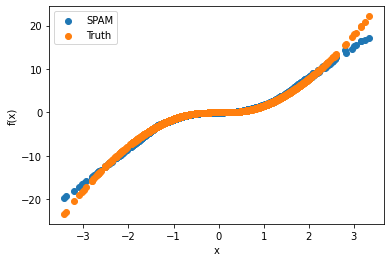

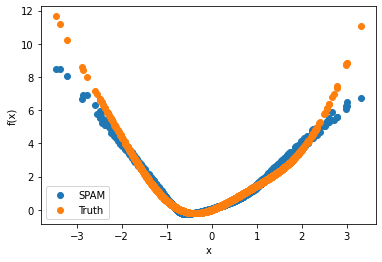

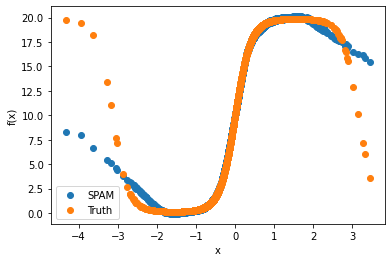

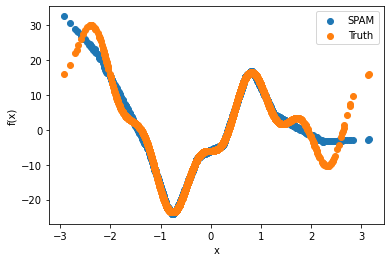

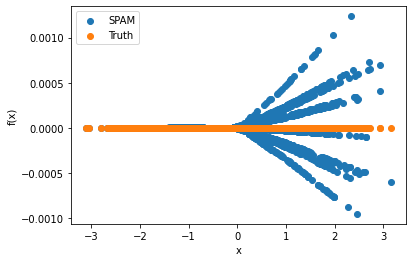

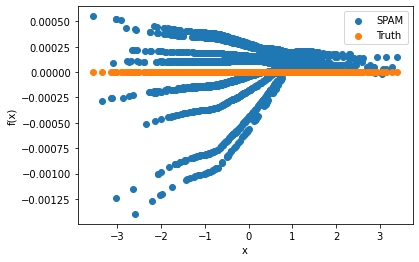

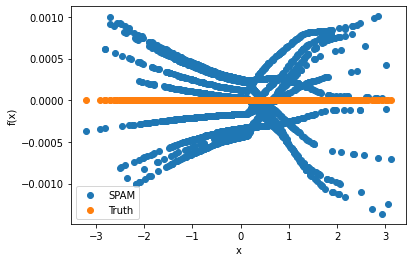

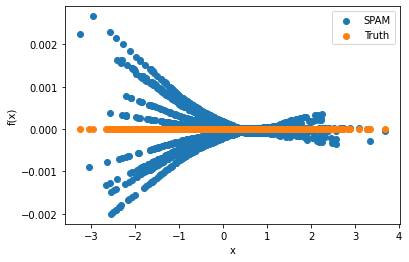

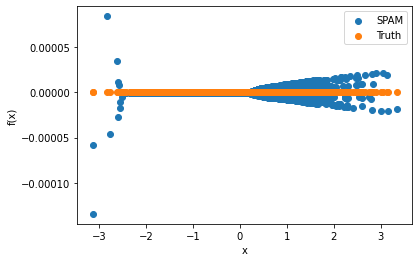

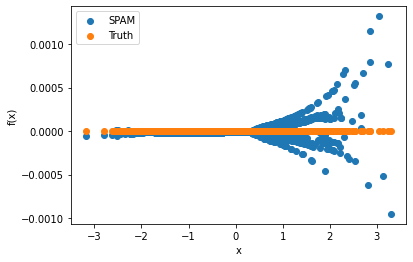

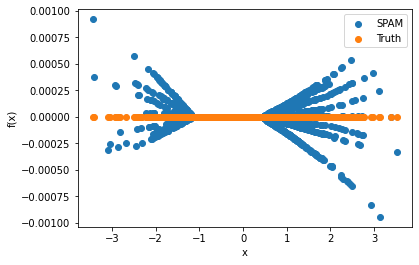

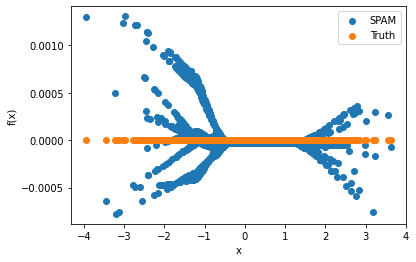

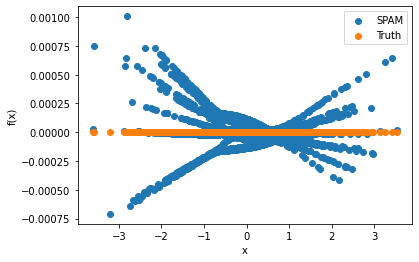

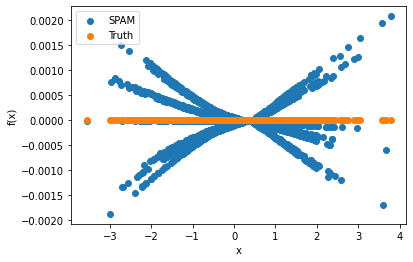

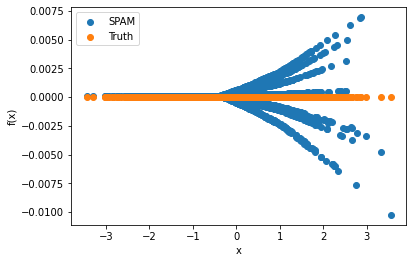

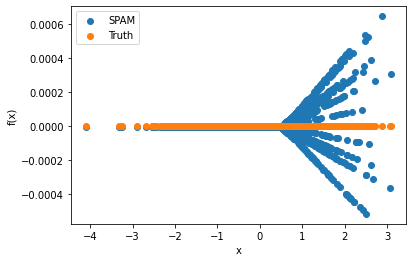

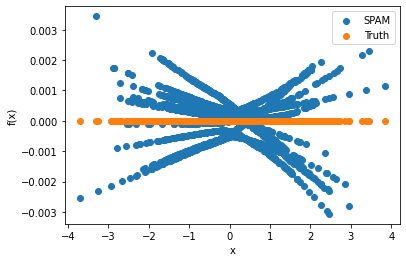

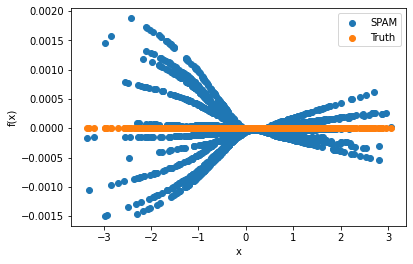

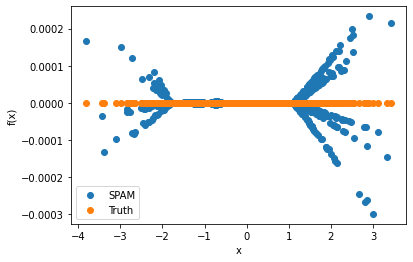

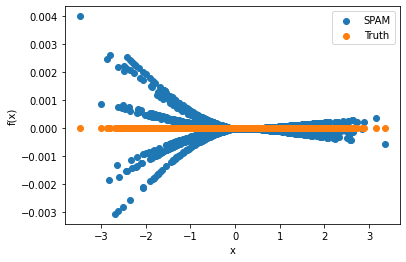

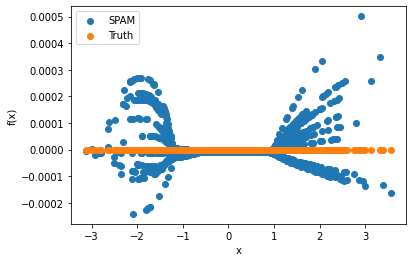

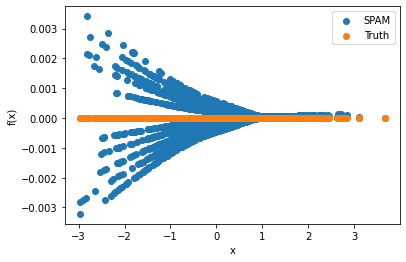

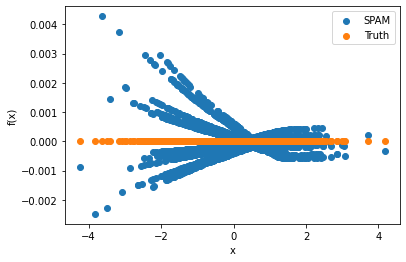

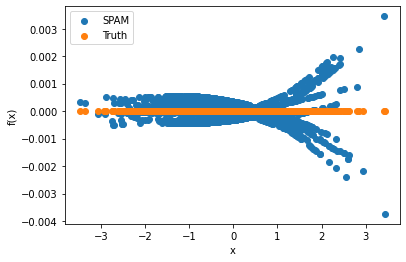

f_tr_out:  [[-2.2386305e+00]
 [ 1.2040515e+00]
 [ 1.6288692e+00]
 [ 7.9905682e+00]
 [-5.0521662e-06]
 [-1.1736445e-04]
 [ 8.9673449e-05]
 [ 3.1310843e-05]
 [ 4.5116667e-07]
 [ 1.1525430e-05]
 [ 1.8040635e-06]
 [ 2.9172541e-05]
 [ 3.2383243e-05]
 [ 2.0239015e-05]
 [-1.2815093e-04]
 [ 7.3166416e-06]
 [ 8.5054926e-05]
 [ 3.4348774e-05]
 [ 3.7941777e-07]
 [ 1.5981233e-05]
 [ 9.6935710e-06]
 [-4.6752386e-05]
 [ 1.0398414e-04]
 [ 5.8374990e-05]]
time spent:  51.430681467056274  sec
test loss:  10.605388641357422
AUC score:  1.0
precision:  1.0
recall:  1.0
iden error:  0.6905886767253073


In [ ]:
data_name = 'data_rg'
[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))

lbd, lr, max_epoch, MSE, n_features=2, 5e-3, int(100), True, X_train.shape[1]
trainloader, testloader, output_size = data_totensor(X_train, X_test, y_train, y_test, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr, f_out_te, model] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE)
time_spent =  time.time()-start 

iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)
print('precision: ', precision_score(true_feature,np.mean(np.abs(f_out_tr), axis=0)>0.01))
print('recall: ', recall_score(true_feature,np.mean(np.abs(f_out_tr), axis=0)>0.01))
print('iden error: ', iden_error)

In [ ]:
##%%save
# f = open(path+"plot_synRG_snam.pkl","wb")
# pickle.dump([test_loss, f_out_tr, f_out_te, model], f)
# f.close()

# ##%%load
[test_loss, f_out_tr, f_out_te, model] = \
pickle.load(open(path+"plot_synRG_snam.pkl", "rb"))

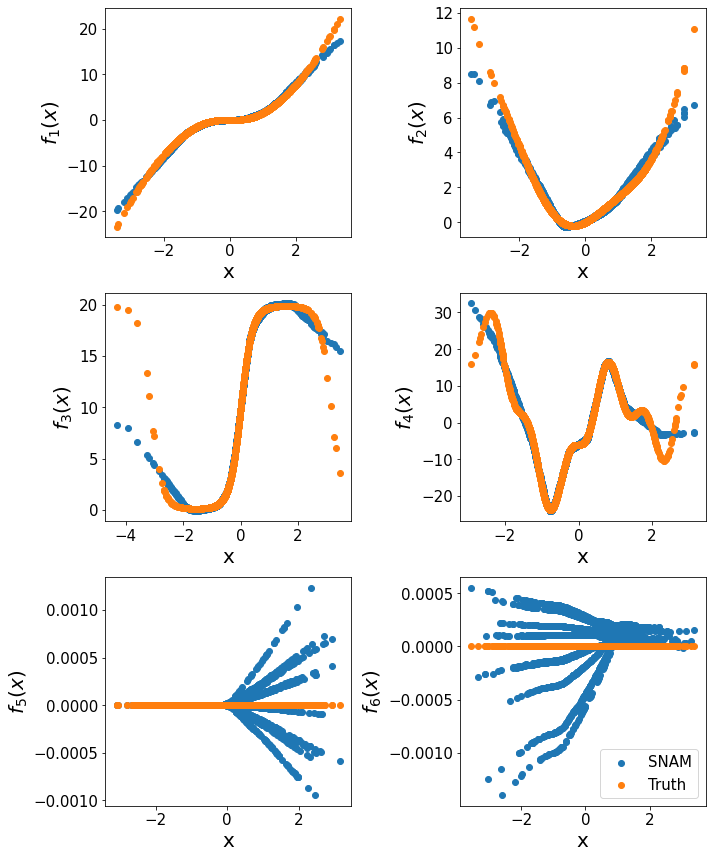

In [ ]:
f_tr = f_out_tr
for i in range(f_tr.shape[1]):
    if i < len(features):
        f_i = features[i](X_train[:, i])
    else: f_i = np.zeros_like(X_train[:, i])
    c_i=np.mean(f_tr[:,[i]]-f_i)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        c_i=np.mean(f_tr[:,[i]]-f_i) 

        col.scatter(X_train[:, i], f_tr[:, [i]]-c_i, label='SNAM')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 5:
            col.legend(fontsize='15')
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_snam.pdf', bbox_inches='tight')
plt.show()        